Using the animal control incident call log, I've selected the dog species as a target, using only color, breed, and size for predictive features in attempt to predict a dangerous/bite situation, or a non-dangerous situation. I would like to think that the color, size, and breed of a dog isn't as deterministic of it's risk/lack of risk of harming others, but I will approach this with the goal of finding otherwise.

## import libraries, packages, data

### libraries, packages

In [1]:
#import
import pandas as pd
import numpy as np
# import seaborn as sns
# sns.set(style='darkgrid')
import matplotlib.pyplot as plt
# %matplotlib inline
# import pandas_profiling
# import datetime
# import re
# import pprint
# pp = pprint.PrettyPrinter(indent=4)
# from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#display multiple outputs from cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#importing libraries & packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#display multiple outputs from cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# machine learning
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import svm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix

Using TensorFlow backend.


### import clean data from part 1

In [3]:
# import Animal Control Incidents df
df = pd.read_csv('a_control.csv')

In [4]:
#df.info()

In [5]:
df = df[df['species']=='dog']

df.service_type.value_counts()

df = df[['breed', 'size', 'color', 'service_type']]

for word in ('loose_stray', 'sick_inj', 'owned', 'trapped_animal', 'patrol', 'school_call'
            ,'other', 'pit', 'snake', 'pick_up_trap', 'cruelty'):
    df['service_type'] = df['service_type'].replace(word, 'not_bite/dang')

df=df.dropna()

loose_stray       12511
cruelty            1957
bite_dangerous     1878
sick_inj           1368
owned              1321
trapped_animal     1042
patrol              712
school_call         172
other                93
pit                   8
snake                 4
pick_up_trap          1
Name: service_type, dtype: int64

In [6]:
# # assign target
y = df["service_type"]

#remove target from features
df.drop(columns= ['service_type'], axis=1, inplace=True)

# dummy categorical features
#col_list = list(df.select_dtypes(include=['object']).columns)
col_list = list(df.columns)

# create dummies for categorical features, assign to X
df = pd.DataFrame(pd.get_dummies(data=df, drop_first=True
                   , prefix=col_list))
X = df


In [7]:

# X_train_d and y_train_d = using original standard test train spit dad
# that way, I can try out different resampling methods
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=33)

### functions

In [8]:
# print model report
def model_report(model): 
    
    print('\nCross Validation Scoring:\n')
    
    train_score = model.score(X_train, y_train)
    print("train score: {:.4}%".format(train_score * 100))

    test_score = model.score(X_test, y_test)
    print("test score: {:.4}%".format(test_score * 100))
   
    cv_score = np.mean(cross_val_score(model, X, y, cv=3))
    print("cross val score: {:.4}%".format(cv_score * 100))

    print("\nClassification Report:")
    print(classification_report(actuals, predictions))
        

    col_list = []
    ind_list = []                     

    for x in y_test.unique():
        col_list.append('pred_'+ x)
        ind_list.append('real_'+x) 

    print('\nConfusion matrix:'.format(accuracy_score))
    display(pd.DataFrame(confusion_matrix(y_test, predictions)
                             , columns=col_list, index=ind_list))


In [9]:
def plot_feats(model):
    n_features = X.shape[1]
    plt.figure(figsize=(8,10))
#     plt.barh(range(n_features), model.feature_importances_, align='center') 
#     plt.yticks(np.arange(n_features), (X.columns.values)) 
#     plt.xlabel("Feature importance")
#     plt.ylabel("Feature")
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(25).plot(kind='barh');
    plt.show();

In [22]:
def plot_matrix(classifier):

    disp = plot_confusion_matrix(classifier, X_test, y_test,
    #                                  display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize='true')
    plt.show();


## prep data

### resampling

Due to the imbalance of class data, it could be beneficial to resample to compensate for the missing data. Using smote to oversample, then random undersampling is a common practice in these circumstances



In [11]:
over = SMOTE(sampling_strategy='minority', random_state=3)
under = RandomUnderSampler( sampling_strategy='majority',
    random_state=3)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# # transform the dataset
X_train, y_train = under.fit_resample(X_train, y_train)

In [12]:
print (y_train.value_counts())

bite_dangerous    1261
not_bite/dang     1261
Name: service_type, dtype: int64


## __modeling__

Logistic Regression basic default model

In [13]:
lr = LogisticRegression(random_state=3)
lr.fit(X_train, y_train)
 
# Predict on training set
predictions = lr.predict(X_test)
actuals = y_test

model_report(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Cross Validation Scoring:

train score: 64.16%
test score: 63.53%
cross val score: 91.04%

Classification Report:
                precision    recall  f1-score   support

bite_dangerous       0.14      0.57      0.22       540
 not_bite/dang       0.94      0.64      0.76      5495

      accuracy                           0.64      6035
     macro avg       0.54      0.61      0.49      6035
  weighted avg       0.87      0.64      0.71      6035


Confusion matrix:


,pred_bite_dangerous,pred_not_bite/dang
real_bite_dangerous,308,232
real_not_bite/dang,1969,3526


### decision tree

__default model__

In [14]:
# initialize and fit default decision tree
dt_model = DecisionTreeClassifier(random_state=3)
dt_model.fit(X_train, y_train)
predictions = dt_model.predict(X_test)
#actuals = y_test

model_report(dt_model)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3, splitter='best')


Cross Validation Scoring:

train score: 72.72%
test score: 52.44%
cross val score: 90.0%

Classification Report:
                precision    recall  f1-score   support

bite_dangerous       0.11      0.62      0.19       540
 not_bite/dang       0.93      0.52      0.66      5495

      accuracy                           0.52      6035
     macro avg       0.52      0.57      0.43      6035
  weighted avg       0.86      0.52      0.62      6035


Confusion matrix:


,pred_bite_dangerous,pred_not_bite/dang
real_bite_dangerous,333,207
real_not_bite/dang,2663,2832


#### grid searches

In [15]:
# set random search params
criterion=['gini','entropy']
max_leaf_nodes = [None]
max_features = [50,60,65,70,80]
max_depth = [5,10,15,20,25]
min_samples_split = [1,2,3,4,5]
min_samples_leaf = [6,8,10,12,15]

random_grid = {'criterion':criterion,
               'max_leaf_nodes': max_leaf_nodes,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }

# random grid search
dt_random = RandomizedSearchCV(estimator = dt_model
                               , param_distributions = random_grid
                               , n_iter = 100, cv = 5, verbose=3, error_score=0
                               , scoring=('f1_macro')
                               , random_state=3, n_jobs = -1);
# fit random search model
dt_random.fit(X_train, y_train);

print('best score: {:.4}%'.format(dt_random.best_score_ * 100));
print(dt_random.best_params_);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    9.7s


best score: 60.41%
{'min_samples_split': 4, 'min_samples_leaf': 10, 'max_leaf_nodes': None, 'max_features': 80, 'max_depth': 10, 'criterion': 'gini'}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   11.7s finished


__grid search__

In [16]:
# grid search params
param_grid_dt = {'criterion': ['entropy', 'gini'],
    'max_depth': [15,16,17,18,20],
    'min_samples_split': [1,2,3,4,5],
    'min_samples_leaf': [7,8,9,10],
     'max_features':[60,62,63,65,67],
     'max_leaf_nodes':[None]
        }

# grid search
gs_dt = GridSearchCV(estimator=dt_model,param_grid=param_grid_dt,
                    error_score=0,scoring=('f1_macro'),
                    cv=5, n_jobs=-1, verbose=2)

# fitting grid search
gs_dt.fit(X_train, y_train)

# best parameters
print('Best score: {:.3}%'.format(gs_dt.best_score_ * 100))
print('params:\n', gs_dt.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 2140 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 3600 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score=0,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=3, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [15, 16, 17, 18, 20],
            

Best score: 60.7%
params:
 {'criterion': 'gini', 'max_depth': 15, 'max_features': 63, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [17]:
# using best params to fit model
dt_gs_model = DecisionTreeClassifier(criterion='entropy',
                              max_depth=16,
                              max_features=65,
                              max_leaf_nodes= None,
                               min_samples_leaf=9,
                               min_samples_split=2
                                 )
dt_gs_model.fit(X_train, y_train)

predictions = dt_gs_model.predict(X_test)
actuals = y_test

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=16, max_features=65, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### final model

In [18]:
model_report(dt_gs_model)


Cross Validation Scoring:

train score: 63.08%
test score: 62.47%
cross val score: 91.05%

Classification Report:
                precision    recall  f1-score   support

bite_dangerous       0.12      0.52      0.20       540
 not_bite/dang       0.93      0.63      0.75      5495

      accuracy                           0.62      6035
     macro avg       0.53      0.58      0.48      6035
  weighted avg       0.86      0.62      0.71      6035


Confusion matrix:


,pred_bite_dangerous,pred_not_bite/dang
real_bite_dangerous,283,257
real_not_bite/dang,2008,3487


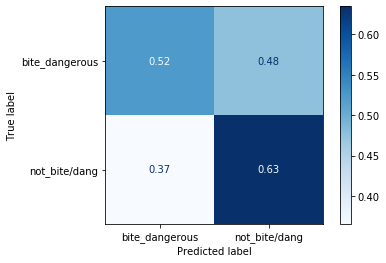

In [23]:
plot_matrix(dt_gs_model)

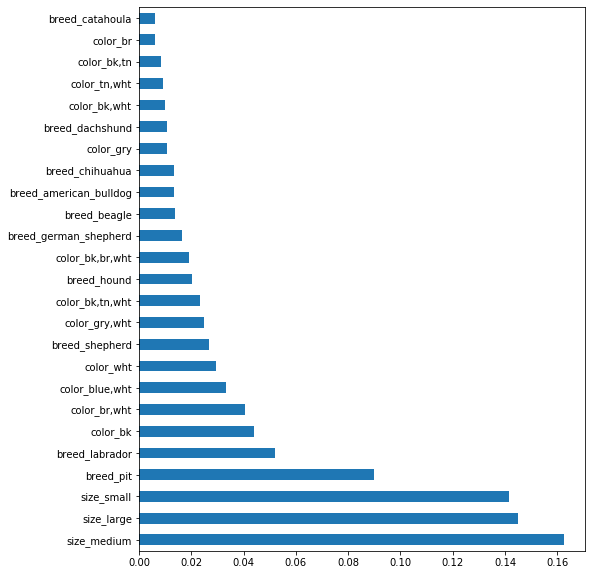

In [24]:


plot_feats(dt_gs_model)

### Random Forest

---
__default model__

In [25]:
#initialize and fit random forest
rf_model = RandomForestClassifier(random_state=3)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
#actuals = y_test

model_report(rf_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


Cross Validation Scoring:

train score: 72.72%
test score: 57.2%
cross val score: 90.54%

Classification Report:
                precision    recall  f1-score   support

bite_dangerous       0.12      0.59      0.20       540
 not_bite/dang       0.93      0.57      0.71      5495

      accuracy                           0.57      6035
     macro avg       0.53      0.58      0.45      6035
  weighted avg       0.86      0.57      0.66      6035


Confusion matrix:


,pred_bite_dangerous,pred_not_bite/dang
real_bite_dangerous,318,222
real_not_bite/dang,2361,3134


#### grid searches

___
__Random Grid Search__

The default model is overfitting. Some ways to avoid overfitting with random forests are: increasing the n_estimators, reducing max features, limiting max depth, and increasing min leaf samples can help construct a more robust fit. Being that it did perform well despite the overfitting, I decided not to go crazy playing with the parameters.

In [ ]:
# set random search params

n_estimators = [600,800,700,1000,1500]
min_weight_fraction_leaf=[0.0, 0.0001, 0.00001]
min_samples_split = [3,4,5,6,7,8]
min_samples_leaf = [1]
min_impurity_split = [0.0]
min_impurity_decrease = [0.0, 0.0001, 0.01]
max_samples = [None]
max_leaf_nodes = [None, 3,10,15,20,25,30]
max_features = ['auto', 3,5,6,8,10,50]
max_depth = [10,30,60,70,80,100,130]
criterion = ['entropy', 'gini']
bootstrap = [True, False]

# Create the random grid
random_grid = { 'n_estimators': n_estimators,
                 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'min_impurity_split': min_impurity_split,
                 'min_impurity_decrease': min_impurity_decrease,
                 'max_samples': max_samples,
                 'max_leaf_nodes': max_leaf_nodes,
                 'max_features': max_features,
                  'max_depth': max_depth,
                 'criterion': criterion,
                 'bootstrap': bootstrap
              }

# fit and search random param combinations
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid
                               , n_iter = 150, cv = 5, verbose=5
                               , random_state=1, scoring='f1_macro', n_jobs = -1);
# Fit the random search model
rf_random.fit(X_train, y_train);

# print best parameters
print('best score: {:.4}%'.format(rf_random.best_score_ * 100));
print(rf_random.best_params_);

___
__grid search__

In [ ]:
param_grid_rf = {
        'n_estimators': [1350,1400,1450]
         , 'min_samples_leaf': [1,2]
         , 'min_samples_split':[6,7,8]
        , 'max_samples': [None]
       , 'max_leaf_nodes':[13,14,15]
         , 'max_features': ['auto']
         , 'max_depth': [70,75,80]
         , 'criterion': [ 'entropy','gini']
         , 'bootstrap': [False]
}

# grid search
gs_rf = GridSearchCV(estimator=rf_model,param_grid=param_grid_rf
                    ,cv=5,scoring='f1_macro',refit=True,error_score=0
                    , n_jobs=-1, verbose=5)

# fitting grid search
gs_rf.fit(X_train, y_train);

# best parameters
print('best score: {:.4}%'.format(gs_rf.best_score_ * 100));
print('params:\n', gs_rf.best_params_);

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min


#### final model

___
__best model__

In [ ]:
# fitting model using best params
rf_gs_model = RandomForestClassifier(
                                   bootstrap= False
                                    ,criterion= 'gini'
                                    , max_depth= 75
                                   , max_features = 'auto'
                                   , max_leaf_nodes = 14
                                   , max_samples = None
                                    , min_samples_leaf = 1
                                   , min_samples_split = 7
                                    , n_estimators = 1400
                                    );
rf_gs_model.fit(X_train, y_train);

predictions = rf_gs_model.predict(X_test);

# new model report
model_report(rf_gs_model)

In [ ]:
plot_matrix(rf_gs_model)

In [ ]:
plot_feats(rf_gs_model)

### AdaBoost

In [ ]:
#initialize and fit default model
ada_model = AdaBoostClassifier(random_state=3)
ada_model.fit(X_train, y_train)

predictions = ada_model.predict(X_test)
# actuals = y_test

___
__Default Model__

In [ ]:
model_report(ada_model)

#### grid searches

__Random Grid Search__

In [ ]:
#set random search params
learning_rate= [.09,.1,1,1.5,2]

n_estimators = [50,100,200,500]

random_grid = {'learning_rate':learning_rate,
               'n_estimators': n_estimators
              }

#random grid search
ada_random = RandomizedSearchCV(estimator = ada_model
                               , param_distributions = random_grid
                               , n_iter = 10, cv = 5, verbose=7, scoring='f1_macro'
                               , random_state=3, n_jobs = -1)
# Fit the random search model
ada_random.fit(X_train, y_train)

ada_random.best_params_

___
__grid search__

In [ ]:
#grid search params and fitting grid search
param_grid_ada = [
    {'n_estimators': [195,197,200,202,205],
    'learning_rate': [0.08, 0.09, 0.1, 0.11,0.12]}
]

# Construct Grid Search
gs_ada = GridSearchCV(estimator=ada_model,
                    param_grid=param_grid_ada,
                    scoring='f1_macro',
                    cv=5, n_jobs=-1, verbose=2)

# Fit using grid search
gs_ada.fit(X_train, y_train);

# Best accuracy and parameters
print('best score: {:.4}%'.format(gs_ada.best_score_ * 100))
print('params:\n', gs_ada.best_params_)

In [ ]:
# fit best params
ada_gs_model = AdaBoostClassifier(n_estimators=200,
                                   learning_rate=.1)
ada_gs_model.fit(X_train, y_train);

predictions = ada_gs_model.predict(X_test)

#### final model

__best model__

In [ ]:
model_report(ada_gs_model)

### gradient boost

In [ ]:
#initialize and fit gradient boost
gbt_model = GradientBoostingClassifier(random_state=3)
gbt_model.fit(X_train, y_train)

predictions = gbt_model.predict(X_test)
# actuals = y_test

__default model__

In [ ]:
#baseline model report
model_report(gbt_model)

#### grid searches

__random grid search__

In [ ]:
# setting parameters for random search
learning_rate=[.09,.1]
#loss = ['deviance', 'exponential']
max_depth = [None] 
n_estimators = [10,30,50]
min_samples_split = [2,3,4]
min_samples_leaf = [1,2,3,4]
min_weight_fraction_leaf = [0, 0.00001]

random_grid = {'learning_rate':learning_rate,
            #  'loss': loss,
               'max_depth': max_depth,
               'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               ,'min_weight_fraction_leaf': min_weight_fraction_leaf
               }

#searching random params
gbt_random = RandomizedSearchCV(estimator = gbt_model, param_distributions = random_grid
                               , n_iter = 25, cv = 5, verbose=3, scoring='f1_macro'
                               , random_state=3, n_jobs = -1)
# fit random search model
gbt_random.fit(X_train, y_train)

print('best score: {:.4}%'.format(gbt_random.best_score_ * 100));
print(gbt_random.best_params_)

__grid search__

In [ ]:
# grid search params and run search
param_grid_gbt = [
    {'n_estimators': [11,12],
     'min_weight_fraction_leaf':[0, 0.001],
    'learning_rate': [0.09,0.1],
    'min_samples_split': [4,5],
    'min_samples_leaf': [1],
    'max_depth': [None],
     'loss':['deviance', 'exponential']
    }]
# grid search
gs_gbt = GridSearchCV(estimator=gbt_model,
                    param_grid=param_grid_gbt,scoring='f1_macro',
                    cv=5, n_jobs=-1, verbose=2)

# fit grid search
gs_gbt.fit(X_train, y_train)

# best params
print('best score: {:.4}%'.format(gs_gbt.best_score_ * 100))
print('params:\n', gs_gbt.best_params_)

In [ ]:
# fitting best params
gbt_gs_model = GradientBoostingClassifier(learning_rate=0.09,
                                          loss= 'deviance',
                                         max_depth=None,
                                         min_samples_leaf=1,
                                         min_samples_split=4,
                                         min_weight_fraction_leaf=0.001,
                                         n_estimators=11)
gbt_gs_model.fit(X_train, y_train)

predictions = gbt_gs_model.predict(X_test)

#### final model

__best model__

In [ ]:
# new model report
model_report(gbt_gs_model)

### SVM

In [ ]:
svm_model = svm.SVC(random_state=3)
svm_model.fit(X_train, y_train)

predictions = svm_model.predict(X_test)
# actuals = y_test

___
__default model__

In [ ]:
model_report(svm_model)

#### grid searches

___
__random grid search__

In [ ]:
# # set random search params
# clf_C = [0.09,1.0, 1.01]
# clf_gamma = [0.001,0.01, 0.1]
# clf_kernel = ['rbf', 'linear']

# random_grid = {
#                'C': clf_C,
#                'gamma': clf_gamma,
#                'kernel': clf_kernel
#                }

# # fit and search random param combinations
# svm_random = RandomizedSearchCV(estimator = svm_model, param_distributions = random_grid
#                                , n_iter = 30 , cv = 5, verbose=10
#                                , scoring='f1_macro', random_state=3, n_jobs = -1)
# # Fit the random search model
# svm_random.fit(X_train, y_train)

# print('best score: {:.4}%'.format(svm_random.best_score_ * 100));
# print(svm_random.best_params_)

___
__grid search__

In [ ]:
# Set grid search params
param_grid_svm = [
  {'C': [0.9,1.0, 1.1], 'gamma': [0.001, 0.01, 0.1]
   , 'kernel': ['rbf', 'linear']
  }]
 
# Construct grid search
gs_svm = GridSearchCV(estimator=svm_model,
            param_grid=param_grid_svm, scoring='f1_macro'
            , cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_svm.fit(X_train, y_train)

# Best accuracy
print('best score: {:.4}%'.format(gs_svm.best_score_ * 100));
print('\nBest params:\n', gs_svm.best_params_)

In [ ]:
svm_gs_model = svm.SVC(C=0.5
                       ,gamma=0.002
                        ,kernel='linear'
                             )
svm_gs_model.fit(X_train, y_train)

predictions = svm_gs_model.predict(X_test)

#### final model

___
__best model__

In [ ]:
model_report(svm_gs_model)

### XGBoost

In [ ]:
# initiate model
xgb_model = XGBClassifier(random_state=3)
xgb_model.fit(X_train, y_train)

predictions = xgb_model.predict(X_test)
# actuals = y_test

In [ ]:
model_report(xgb_model)

#### grid searches

In [ ]:
#set random search params
learning_rate=[.009,.01,.25,.2,.15 ,.1]
max_depth = [2,3,4,5,6,7,8,9]
min_child_weight = [.8,1,1.5,1.9,2]
n_estimators = [70,80,90,100, 110,150,200,250]
min_weight_fraction_leaf = [0,0.0001,0.005, 0.01, 1]
gamma = [0.0, 0.001,0.005, 0.01]

random_grid = {
               'learning_rate':learning_rate
               ,'max_depth': max_depth
               ,'min_child_weight':min_child_weight
            ,'n_estimators': n_estimators
                , 'gamma': gamma
              }

# searching random params
xgb_random = RandomizedSearchCV(estimator = xgb_model, param_distributions = random_grid
                               , n_iter = 150, cv = 5, verbose=5
                               ,scoring='f1_macro', random_state=3, n_jobs = -1)
# fit random search model
xgb_random.fit(X_train, y_train)
print('best score: {:.4}%'.format(xgb_random.best_score_ * 100));
print(xgb_random.best_params_);

In [ ]:
param_grid_xgb = [
    {
         'gamma':[0.1,0.01, 0.001],
        'min_child_weight': [.9,1.0, 1.1, 1.3],
    'learning_rate': [0.01,0.05,.1, 0.13],
    'n_estimators': [70,80,90],
    'max_depth': [8,9,10]
    }
]

# Construct Grid Search
gs_xgb = GridSearchCV(estimator=xgb_model,
                    param_grid=param_grid_xgb,
                    scoring='f1_macro',
                    cv=3, n_jobs=-1, verbose=10)

# Fit using grid search
gs_xgb.fit(X, y)

# Best accuracy and parameters
print('best score: {:.3}%'.format(gs_xgb.best_score_ * 100))
print('params:\n', gs_xgb.best_params_);

#### final model

In [ ]:
# fit using best params
xgb_gs_model = XGBClassifier(learning_rate=0.01,
                             gamma=0.01,
                            max_depth=9,
                             min_child_weight=.9,
                             n_estimators=80)
xgb_gs_model.fit(X_train, y_train)

predictions = xgb_gs_model.predict(X_test)

model_report(xgb_gs_model)